# Detect AI vs. Human-Generated Images
2025 Women in AI (WAI) Kaggle Challenge

label
1    39975
0    39975
Name: count, dtype: int64


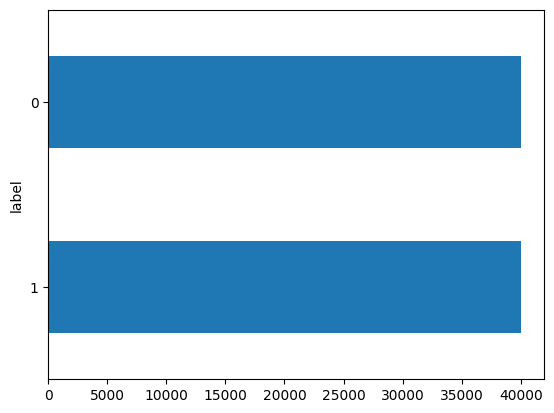

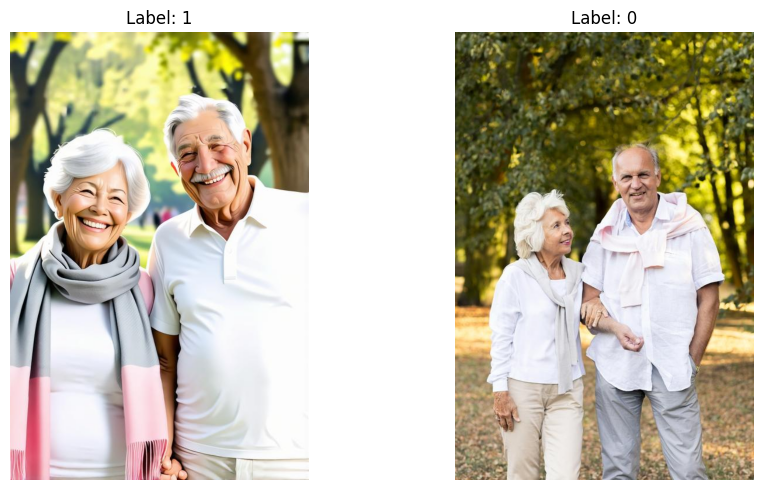

Train Data:


,Unnamed: 0,file_name,label
0,0,/Users/andrewxue/Documents/AI vs. Human Image ...,1
1,1,/Users/andrewxue/Documents/AI vs. Human Image ...,0
2,2,/Users/andrewxue/Documents/AI vs. Human Image ...,1
3,3,/Users/andrewxue/Documents/AI vs. Human Image ...,0
4,4,/Users/andrewxue/Documents/AI vs. Human Image ...,1


In [2]:
import pandas as pd
import PIL
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from collections import Counter
# Load the test CSV for predictions
test_csv_path = "/Users/andrewxue/Documents/AI vs. Human Image Classification/archive/train.csv"
df = pd.read_csv(test_csv_path)

# Define the base directory where images are stored
train_data_dir = "/Users/andrewxue/Documents/AI vs. Human Image Classification/archive"

# Update image paths in the test dataframe
df['file_name'] = df['file_name'].apply(lambda x: os.path.join(train_data_dir, x))

df['label'].value_counts().plot(kind = 'barh')
print(df['label'].value_counts())

# Display the first pair of images
def show_image_pair(df):
    # Select first two images
    first_two = df.iloc[:2]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    for i, row in enumerate(first_two.itertuples()):
        img_path = row.file_name
        label = row.label
        
        # Load image using PIL
        image = Image.open(img_path).convert("RGB")
        
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to show images
show_image_pair(df)

# Show Dataframe
print("Train Data:")
df.head()

In [3]:
# Drop Un-needed Data
df = df.drop(columns=['Unnamed: 0'])

print("Train Data:")
df.head()

Train Data:


,file_name,label
0,/Users/andrewxue/Documents/AI vs. Human Image ...,1
1,/Users/andrewxue/Documents/AI vs. Human Image ...,0
2,/Users/andrewxue/Documents/AI vs. Human Image ...,1
3,/Users/andrewxue/Documents/AI vs. Human Image ...,0
4,/Users/andrewxue/Documents/AI vs. Human Image ...,1


# MAN Architecture


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class MultiScaleAttention(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.query(x).view(batch_size, -1, H * W).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, H * W)
        value = self.value(x).view(batch_size, -1, H * W)
        
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, H, W)
        return self.gamma * out + x

class FrequencyAwareModule(nn.Module):
    def __init__(self, channels):
        super(FrequencyAwareModule, self).__init__()
        self.high_pass = nn.Conv2d(channels, channels, kernel_size=3, padding=1, groups=channels, bias=False)
        nn.init.xavier_uniform_(self.high_pass.weight)
        self.attention = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        high_freq = self.high_pass(x)
        combined = torch.cat([x, high_freq], dim=1)
        attention_weights = self.attention(combined)
        return x * attention_weights

class ImprovedAIDetector(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedAIDetector, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks with increasing channels
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        # Multi-scale attention modules
        self.attention1 = MultiScaleAttention(64)
        self.attention2 = MultiScaleAttention(128)
        self.attention3 = MultiScaleAttention(256)
        
        # Frequency-aware modules
        self.freq1 = FrequencyAwareModule(64)
        self.freq2 = FrequencyAwareModule(128)
        self.freq3 = FrequencyAwareModule(256)
        
        # Global pooling and classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution
        x = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        
        # First block with attention and frequency awareness
        x = self.layer1(x)
        x = self.attention1(x)
        x = self.freq1(x)
        
        # Second block
        x = self.layer2(x)
        x = self.attention2(x)
        x = self.freq2(x)
        
        # Third block
        x = self.layer3(x)
        x = self.attention3(x)
        x = self.freq3(x)
        
        # Classification
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

# Example usage
def get_model():
    model = ImprovedAIDetector(num_classes=2)
    return model

# Data Augmentation
a) Geometric Augmentations:

RandomResizedCrop 
Random flips (horizontal and vertical)
Random rotation
These help the model become invariant to image orientation and cropping

b) Color and Intensity Augmentations:

ColorJitter (brightness, contrast, saturation, hue)
RandomAutocontrast
These help prevent the model from relying too heavily on color patterns

c) Noise and Artifact Augmentations:

GaussianBlur
JPEG compression simulation
Random noise addition
These help simulate different image quality conditions


Training Pipeline Features:


Gradient clipping to prevent exploding gradients
Cosine annealing learning rate scheduler
Separate validation transform without augmentations
Complete training and validation loops

In [5]:
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import random

class AIImageAugmentation:
    def __init__(self, image_size=224):
        self.train_transform = transforms.Compose([
            # Geometric augmentations
            transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            
            # Color and intensity augmentations
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAutocontrast(p=0.2),
            
            # Noise and blur augmentations
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            
            # Normalization
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Validation transform without augmentations
        self.val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Additional custom augmentations
        self.jpeg_compression = transforms.Lambda(self._jpeg_compression)
        self.add_noise = transforms.Lambda(self._add_noise)
        
    def _jpeg_compression(self, img):
        """Simulate JPEG compression artifacts"""
        quality = random.randint(60, 100)
        buffer = BytesIO()
        img.save(buffer, "JPEG", quality=quality)
        buffer.seek(0)
        img = Image.open(buffer)
        return img
        
    def _add_noise(self, tensor):
        """Add random noise to the image"""
        noise = torch.randn_like(tensor) * random.uniform(0.01, 0.05)
        return torch.clamp(tensor + noise, 0, 1)

# Train Model

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
from PIL import Image
import os
from pathlib import Path
import numpy as np
from sklearn.metrics import f1_score

# Create checkpoints directory
Path("checkpoints").mkdir(exist_ok=True)

def save_checkpoint(model, optimizer, epoch, metrics, filename):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics
    }
    torch.save(checkpoint, filename)

class AIHumanImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

def train_ai_detector():
    # Load the dataset
    train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
    train_data_dir = "/kaggle/input/ai-vs-human-generated-dataset"
    
    # Read and prepare DataFrame
    df = pd.read_csv(train_csv_path)
    df['file_name'] = df['file_name'].apply(lambda x: os.path.join(train_data_dir, x))
    
    # Split into train and validation sets
    train_df = df.sample(frac=0.8, random_state=42)
    val_df = df.drop(train_df.index)
    
    # Initialize augmentations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = AIHumanImageDataset(train_df, transform=transform)
    val_dataset = AIHumanImageDataset(val_df, transform=val_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Training configuration
    config = {
        'learning_rate': 1e-4,
        'weight_decay': 1e-2,
        'grad_clip': 1.0,
        'epochs': 15
    }
    
    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ImprovedAIDetector(num_classes=2)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    # Initialize metrics storage
    best_val_f1 = 0.0
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []
    
    print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples")
    
    # Training loop
    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        epoch_predictions = []
        epoch_labels = []
        
        # Training phase
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.detach(), 1)
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_f1 = f1_score(epoch_labels, epoch_predictions, average='weighted')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_epoch_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')
        
        # Store metrics
        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)
        
        # Save current metrics
        current_metrics = {
            'train_loss': epoch_loss,
            'val_loss': val_epoch_loss,
            'train_f1': train_f1,
            'val_f1': val_f1,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_f1_scores': train_f1_scores,
            'val_f1_scores': val_f1_scores
        }
        
        # Save recent checkpoint
        save_checkpoint(
            model,
            optimizer,
            epoch,
            current_metrics,
            'checkpoints/model_recent.pt'
        )
        
        # Save best model if validation F1 score improves
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            save_checkpoint(
                model,
                optimizer,
                epoch,
                current_metrics,
                'checkpoints/model_best.pt'
            )
            print(f"\nNew best model saved! Validation F1: {val_f1:.4f}")
        
        # Print epoch statistics
        print(f"\nEpoch [{epoch+1}/{config['epochs']}]")
        print(f"Training   - Loss: {epoch_loss:.4f}, F1: {train_f1:.4f}")
        print(f"Validation - Loss: {val_epoch_loss:.4f}, F1: {val_f1:.4f}")
    
    return model, 'checkpoints/model_best.pt'

def load_trained_model(model_path):
    """Load a trained model for inference"""
    model = ImprovedAIDetector(num_classes=2)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

ModuleNotFoundError: No module named 'tqdm'

# Initialize Model Training

In [7]:
model, best_model_path = train_ai_detector()

Using device: cpu
Starting model training...


KeyboardInterrupt: 